# DeepLearning_Resnet

## Data Processing

In [ ]:
import os
import shutil
import random

def split_dataset(
    original_data_dir, 
    output_root_dir, 
    train_ratio=0.4, 
    val_ratio=0.4, 
    test_ratio=0.2,
    seed=42
):
    """
    Split the data set into the training set, the validation set and the test set
    
    Parameters:
      train_ratio, val_ratio, test_ratio: The proportion of training, verification and testing
      seed: Random seeds, used for reproduction
    """
    random.seed(seed)
    
    # Create the target folder
    train_dir = os.path.join(output_root_dir, 'train')
    val_dir   = os.path.join(output_root_dir, 'val')
    test_dir  = os.path.join(output_root_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Traverse each category directory
    classes = os.listdir(original_data_dir)
    
    for cls in classes:
        cls_folder = os.path.join(original_data_dir, cls)
        if not os.path.isdir(cls_folder):
            continue  # Skip non-folders
        
        # Create a category folder under the target path
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        images = os.listdir(cls_folder)
        images = [img for img in images if os.path.isfile(os.path.join(cls_folder, img))]

        # Randomly shuffle the list of images
        random.shuffle(images)
        total_count = len(images)
        
        # Calculate the number of images in each set according to the proportion
        train_count = int(total_count * train_ratio)
        val_count   = int(total_count * val_ratio)
        test_count  = total_count - train_count - val_count  # The rest is the test set
        
        train_images = images[:train_count]
        val_images   = images[train_count : train_count + val_count]
        test_images  = images[train_count + val_count:]
        
        # Copy the image to the target folder
        for img in train_images:
            src = os.path.join(cls_folder, img)
            dst = os.path.join(train_dir, cls, img)
            shutil.copyfile(src, dst)

        for img in val_images:
            src = os.path.join(cls_folder, img)
            dst = os.path.join(val_dir, cls, img)
            shutil.copyfile(src, dst)
        
        for img in test_images:
            src = os.path.join(cls_folder, img)
            dst = os.path.join(test_dir, cls, img)
            shutil.copyfile(src, dst)
        
        print(f"[{cls}] total={total_count}, train={len(train_images)}, val={len(val_images)}, test={len(test_images)}")

if __name__ == "__main__":
    # Modify the path according to your environment
    original_data_dir = r"D:\9517project\Aerial_Landscapes"  # Directory of the original dataset
    output_root_dir   = r"D:\9517project\Aerial_Landscapes_Split"  # Output the directory after splitting
    split_dataset(
        original_data_dir, 
        output_root_dir, 
        train_ratio=0.4,   # 40% 
        val_ratio=0.4,     # 40% 
        test_ratio=0.2     # 20% 
    )

[Agriculture] total=800, train=320, val=320, test=160
[Airport] total=800, train=320, val=320, test=160
[Beach] total=800, train=320, val=320, test=160
[City] total=800, train=320, val=320, test=160
[Desert] total=800, train=320, val=320, test=160
[Forest] total=800, train=320, val=320, test=160
[Grassland] total=800, train=320, val=320, test=160
[Highway] total=800, train=320, val=320, test=160
[Lake] total=800, train=320, val=320, test=160
[Mountain] total=800, train=320, val=320, test=160
[Parking] total=800, train=320, val=320, test=160
[Port] total=800, train=320, val=320, test=160
[Railway] total=800, train=320, val=320, test=160
[Residential] total=800, train=320, val=320, test=160
[River] total=800, train=320, val=320, test=160


## model

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

def build_resnet18(num_classes=15, pretrained=True, dropout_p=0.5):
    """
    
    Parameters:
      num_classes (int): Output the number of categories
      pretrained (bool): Whether to use ImageNet pre-training weights
      dropout_p (float): Dropout Probability (default 0.5)

    
    """
    # Use the new version of the interface to avoid pretrained warnings
    weights = ResNet18_Weights.DEFAULT if pretrained else None
    model = resnet18(weights=weights)

    # Obtain the number of input features of the fc layer
    in_features = model.fc.in_features

    # Replace the fc layer: Add Dropout and Linear
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(in_features, num_classes)
    )

    return model

def load_model(model_path, num_classes=15, device=torch.device("cpu")):
    """
    Load the trained model weights and set them to the eval mode
    """
    model = build_resnet18(num_classes=num_classes, pretrained=False)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

if __name__ == "__main__":
    # Test structure
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_resnet18(num_classes=15, pretrained=True, dropout_p=0.5)
    print("ResNet structure：")
    print(model)


ResNet structure：
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

## Model Design and Train

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# ========== Add the EarlyStopping class ==========
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0,
                 save_path=r'D:\9517project\BestModel.pth',
                 verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.save_path = save_path
        self.verbose = verbose

    def __call__(self, val_score, model):
        score = val_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"The accuracy rate has not improved: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        if self.verbose:
            print(f"Accuracy improved. Saving model to {self.save_path}")
        # Ensure the target directory exists
        dir_path = os.path.dirname(self.save_path)
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)
        torch.save(model.state_dict(), self.save_path)


def build_resnet18(num_classes, pretrained=True):
    from torchvision.models import resnet18
    model = resnet18(pretrained=pretrained)
    # Replace the final fully-connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


def main():
    # Parameter configuration
    data_root = r"D:\9517project\Aerial_Landscapes_Split"
    num_classes = 15
    batch_size = 32
    num_epochs = 50
    learning_rate = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Data preprocessing
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    train_dataset = datasets.ImageFolder(os.path.join(data_root, 'train'), transform=train_transform)
    val_dataset   = datasets.ImageFolder(os.path.join(data_root, 'val'),   transform=val_transform)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
    val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)

    # Build the model
    model = build_resnet18(num_classes=num_classes, pretrained=True)
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize EarlyStopping 
    early_stopping = EarlyStopping(patience=5)

    # Training and Validation loop
    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # ===== Training stage =====
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)
            train_bar.set_postfix(loss=loss.item())

        epoch_train_loss = total_train_loss / total_train
        epoch_train_acc  = correct_train / total_train
        print(f"  Train: Loss={epoch_train_loss:.4f}, Acc={epoch_train_acc:.4f}")

        # ===== Validation stage =====
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validating", leave=False)
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
                val_bar.set_postfix(loss=loss.item())

        epoch_val_loss = total_val_loss / total_val
        epoch_val_acc  = correct_val / total_val
        print(f"  Val:   Loss={epoch_val_loss:.4f}, Acc={epoch_val_acc:.4f}")

        # ===== Check EarlyStopping =====
        early_stopping(epoch_val_acc, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Ending training.")
            break

    print("\nTraining complete. Best model has saved")


if __name__ == "__main__":
    main()


Using device: cuda


C:\Users\31649\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch [1/50]


  Train: Loss=0.9511, Acc=0.7092


  Val:   Loss=0.7624, Acc=0.7750
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [2/50]


  Train: Loss=0.5796, Acc=0.8163


  Val:   Loss=1.0036, Acc=0.7367
The accuracy rate has not improved: 1/5

Epoch [3/50]


  Train: Loss=0.4519, Acc=0.8565


  Val:   Loss=0.6087, Acc=0.8083
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [4/50]


  Train: Loss=0.3478, Acc=0.8856


  Val:   Loss=0.4846, Acc=0.8604
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [5/50]


  Train: Loss=0.3037, Acc=0.9079


  Val:   Loss=0.4237, Acc=0.8698
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [6/50]


  Train: Loss=0.2463, Acc=0.9177


  Val:   Loss=0.3548, Acc=0.8948
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [7/50]


  Train: Loss=0.2485, Acc=0.9179


  Val:   Loss=0.3543, Acc=0.8896
The accuracy rate has not improved: 1/5

Epoch [8/50]


  Train: Loss=0.2059, Acc=0.9290


  Val:   Loss=0.3213, Acc=0.9035
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [9/50]


  Train: Loss=0.1620, Acc=0.9479


  Val:   Loss=0.3435, Acc=0.9000
The accuracy rate has not improved: 1/5

Epoch [10/50]


  Train: Loss=0.1410, Acc=0.9535


  Val:   Loss=0.4070, Acc=0.8842
The accuracy rate has not improved: 2/5

Epoch [11/50]


  Train: Loss=0.1609, Acc=0.9508


  Val:   Loss=0.3364, Acc=0.9021
The accuracy rate has not improved: 3/5

Epoch [12/50]


  Train: Loss=0.1369, Acc=0.9537


  Val:   Loss=0.2977, Acc=0.9177
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [13/50]


  Train: Loss=0.0868, Acc=0.9710


  Val:   Loss=0.2724, Acc=0.9258
Accuracy improved. Saving model to D:\9517project\BestModel.pth

Epoch [14/50]


  Train: Loss=0.1438, Acc=0.9527


  Val:   Loss=0.4118, Acc=0.8929
The accuracy rate has not improved: 1/5

Epoch [15/50]


  Train: Loss=0.1136, Acc=0.9629


  Val:   Loss=0.4351, Acc=0.8892
The accuracy rate has not improved: 2/5

Epoch [16/50]


  Train: Loss=0.1180, Acc=0.9608


  Val:   Loss=0.3997, Acc=0.8965
The accuracy rate has not improved: 3/5

Epoch [17/50]


  Train: Loss=0.1057, Acc=0.9656


  Val:   Loss=0.3564, Acc=0.9062
The accuracy rate has not improved: 4/5

Epoch [18/50]


  Train: Loss=0.1107, Acc=0.9627


  Val:   Loss=0.3356, Acc=0.9071
The accuracy rate has not improved: 5/5
Early stopping triggered. Ending training.

Training complete. Best model has saved


## Test

Using device: cuda


C:\Users\31649\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\31649\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Evaluation metrics:
  Accuracy: 0.9346
  Recall:   0.9346
  F1-score: 0.9347

Classification report:
              precision    recall  f1-score   support

 Agriculture       0.93      0.93      0.93       160
     Airport       0.82      0.94      0.87       160
       Beach       0.94      0.96      0.95       160
        City       0.95      0.93      0.94       160
      Desert       0.97      0.93      0.95       160
      Forest       0.98      0.96      0.97       160
   Grassland       0.89      1.00      0.94       160
     Highway       0.91      0.91      0.91       160
        Lake       0.99      0.90      0.94       160
    Mountain       0.91      0.97      0.94       160
     Parking       0.99      0.94      0.96       160
        Port       0.91      0.97      0.94       160
     Railway       0.93      0.86      0.89       160
 Residential       0.98      0.97      0.97       160
       River       0.94      0.86      0.90       160

    accuracy                     

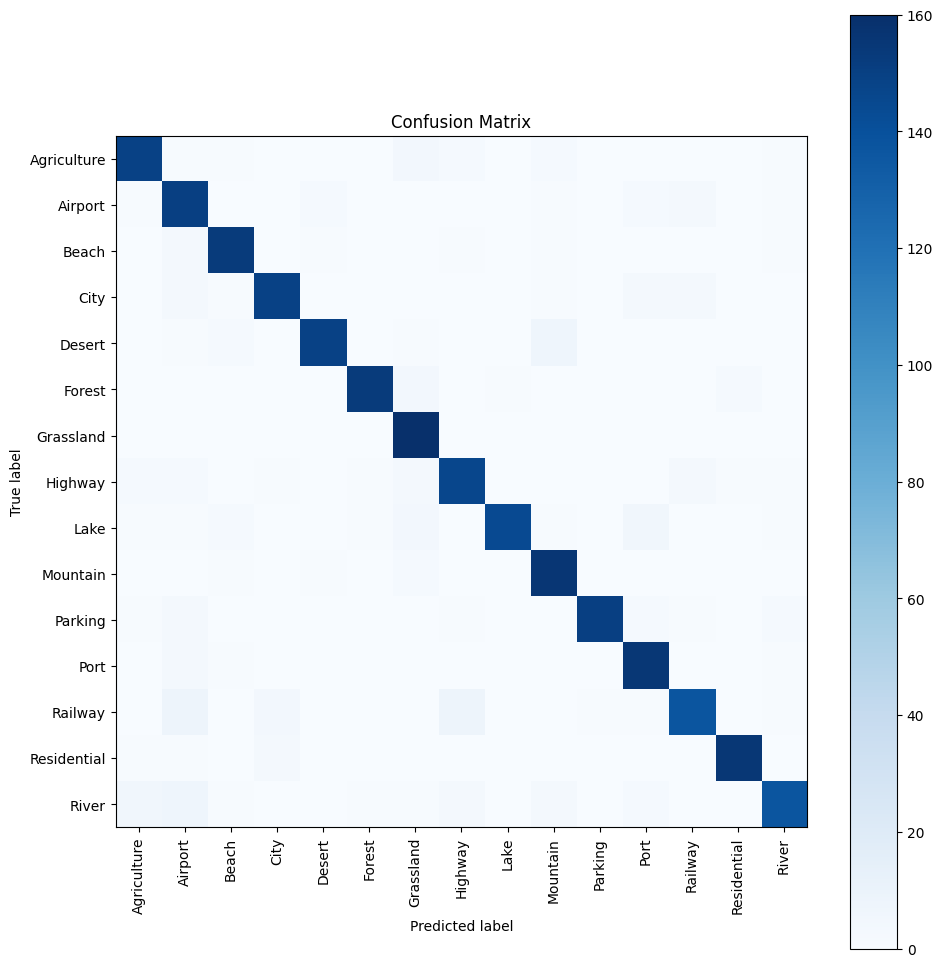

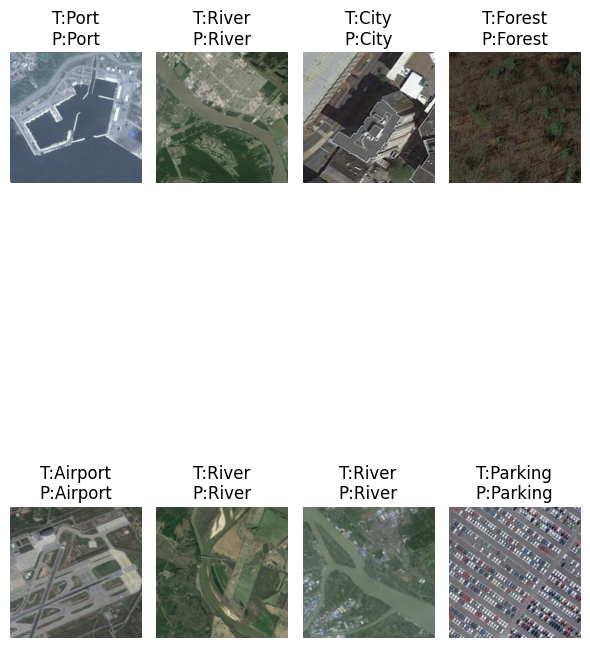

In [29]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

def build_resnet18(num_classes, pretrained=False):
    from torchvision.models import resnet18
    model = resnet18(pretrained=pretrained)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def load_model(model_path, num_classes, device):
    model = build_resnet18(num_classes=num_classes, pretrained=False)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    return model

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(np.clip(img, 0, 1))
    if title:
        plt.title(title)
    plt.axis('off')

def visualize_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=90)
    plt.yticks(ticks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

def visualize_samples(model, dataset, device, inv_normalize, num_samples=8):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    plt.figure(figsize=(3 * (num_samples//4), 3 * 4))
    for i, idx in enumerate(indices):
        img_path, true_label = dataset.samples[idx]
        img = dataset.loader(img_path)
        img_t = dataset.transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_t)
            pred = torch.argmax(output, dim=1).item()

        img_disp = inv_normalize(img_t.squeeze().cpu())
        plt.subplot(num_samples//4, 4, i+1)
        imshow(img_disp, title=f"T:{dataset.classes[true_label]}\nP:{dataset.classes[pred]}")
    plt.tight_layout()
    plt.show()

def evaluate_and_visualize(data_root, model_path, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Normalization and its inverse
    normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
        std=[1/s for s in [0.229,0.224,0.225]]
    )

    test_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ])

    # Load test dataset
    test_dataset = datasets.ImageFolder(
        os.path.join(data_root, 'test'),
        transform=test_transform
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size,
        shuffle=False, num_workers=4
    )

    # Load the trained model from D:\9517project\BestModel.pth
    model = load_model(
        model_path,
        num_classes=len(test_dataset.classes),
        device=device
    )

    # Gather predictions
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc    = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1     = f1_score(all_labels, all_preds, average='macro')

    print("Evaluation metrics:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Recall:   {recall:.4f}")
    print(f"  F1-score: {f1:.4f}\n")
    print("Classification report:")
    print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

    # Plot confusion matrix and sample predictions
    cm = confusion_matrix(all_labels, all_preds)
    visualize_confusion_matrix(cm, test_dataset.classes)
    visualize_samples(model, test_dataset, device, inv_normalize, num_samples=8)

if __name__ == "__main__":
    data_root = r"D:\9517project\Aerial_Landscapes_Split"
    model_path = r"D:\9517project\BestModel.pth"
    evaluate_and_visualize(data_root, model_path)


# DeepLearning_ViT (Vision Transformer)

## Data Processing

In [13]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from transformers import ViTFeatureExtractor

# the dataset path
dataset_path = Path(r'D:\Group 9517\Aerial_Landscapes')

# image pre-processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# print dataset info
print(f"image number: {len(dataset)}")
print(f"label number: {len(dataset.classes)}")
print("label list:")
for idx, class_name in enumerate(dataset.classes):
    print(f"   {idx}: {class_name}")

# 80% Trainset 20% Testset
train_data, test_data = train_test_split(dataset.imgs, test_size=0.2, random_state=42, stratify=[img[1] for img in dataset.imgs])

train_save_dir = Path(r'D:\Group 9517\train_data')
test_save_dir = Path(r'D:\Group 9517\test_data')

train_save_dir.mkdir(parents=True, exist_ok=True)
test_save_dir.mkdir(parents=True, exist_ok=True)

# Create subfolders and categorize them
for class_name in dataset.classes:
    (train_save_dir / class_name).mkdir(parents=True, exist_ok=True)
    (test_save_dir / class_name).mkdir(parents=True, exist_ok=True)

# Save Trainingset
for img_path, label in train_data:
    class_name = dataset.classes[label]
    save_path = train_save_dir / class_name / os.path.basename(img_path)
    shutil.copy(img_path, save_path)

# Save Testset
for img_path, label in test_data:
    class_name = dataset.classes[label]
    save_path = test_save_dir / class_name / os.path.basename(img_path)
    shutil.copy(img_path, save_path)


# Define the ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# creat DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)


image number: 12000
label number: 15
label list:
   0: Agriculture
   1: Airport
   2: Beach
   3: City
   4: Desert
   5: Forest
   6: Grassland
   7: Highway
   8: Lake
   9: Mountain
   10: Parking
   11: Port
   12: Railway
   13: Residential
   14: River


C:\Users\31649\AppData\Roaming\Python\Python311\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Model Design and Train

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# 1. Data Augmentation and Preprocessing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dir = r'D:\Group 9517\train_data'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# 2. Model Creation with DropPath
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    drop_path_rate=0.1
)
model.head = nn.Linear(model.head.in_features, len(train_dataset.classes))

# 3. Device / Optimizer / Loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=0.05
)
criterion = nn.CrossEntropyLoss()

# 4. Learning Rate Scheduler
from torch.optim.lr_scheduler import OneCycleLR
total_steps = len(train_loader) * 20
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos',
    final_div_factor=1e4
)

# 5. Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    avg_loss = train_loss / len(train_loader)
    train_acc = correct / total

    print(f"\nEpoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")

# Save final model
save_path = r"D:\Group 9517\model_vit_final.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"\n✅ Model has been saved to {save_path}")



Train Epoch 1/20:   0%|          | 0/300 [00:00<?, ?it/s]d:\Group 9517\.venv\lib\site-packages\timm\models\vision_transformer.py:93: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(
Train Epoch 1/20: 100%|██████████| 300/300 [02:15<00:00,  2.22it/s]

Epoch 1/20 — Train Loss: 0.6427 | Train Acc: 0.8013
Train Epoch 2/20: 100%|██████████| 300/300 [02:13<00:00,  2.25it/s]

Epoch 2/20 — Train Loss: 1.0739 | Train Acc: 0.6605
Train Epoch 3/20: 100%|██████████| 300/300 [02:15<00:00,  2.22it/s]

Epoch 3/20 — Train Loss: 1.0480 | Train Acc: 0.6575
Train Epoch 4/20: 100%|██████████| 300/300 [02:15<00:00,  2.22it/s]

Epoch 4/20 — Train Loss: 0.9703 | Train Acc: 0.6819
Train Epoch 5/20: 100%|██████████| 300/300 [02:16<00:00,  2.21it/s]

Epoch 5/20 — Train Loss: 0.8442 | Train Acc: 0.7176
Train Epoch 6/20: 100%|██████████| 300/300 [02:15<00:00,  2.21it/s]

Epoch 6/20 — Train Loss: 0.7200 | Train Acc: 0.7590
Train Epoch 7/20: 100%|██████████| 300/300 [02:15<00:00,  2.21it/s]

Epoch 7/20 — Train Loss: 0.6747 | Train Acc: 0.7739
Train Epoch 8/20: 100%|██████████| 300/300 [02:14<00:00,  2.23it/s]

Epoch 8/20 — Train Loss: 0.5721 | Train Acc: 0.8105
Train Epoch 9/20: 100%|██████████| 300/300 [02:13<00:00,  2.25it/s]

Epoch 9/20 — Train Loss: 0.5204 | Train Acc: 0.8275
Train Epoch 10/20: 100%|██████████| 300/300 [02:13<00:00,  2.25it/s]

Epoch 10/20 — Train Loss: 0.4532 | Train Acc: 0.8478
Train Epoch 11/20: 100%|██████████| 300/300 [02:15<00:00,  2.22it/s]

Epoch 11/20 — Train Loss: 0.3943 | Train Acc: 0.8694
Train Epoch 12/20: 100%|██████████| 300/300 [02:16<00:00,  2.19it/s]

Epoch 12/20 — Train Loss: 0.3448 | Train Acc: 0.8822
Train Epoch 13/20: 100%|██████████| 300/300 [02:15<00:00,  2.21it/s]

Epoch 13/20 — Train Loss: 0.2779 | Train Acc: 0.9056
Train Epoch 14/20: 100%|██████████| 300/300 [02:15<00:00,  2.22it/s]

Epoch 14/20 — Train Loss: 0.2240 | Train Acc: 0.9228
Train Epoch 15/20: 100%|██████████| 300/300 [02:16<00:00,  2.19it/s]

Epoch 15/20 — Train Loss: 0.1764 | Train Acc: 0.9386
Train Epoch 16/20: 100%|██████████| 300/300 [02:16<00:00,  2.20it/s]

Epoch 16/20 — Train Loss: 0.1335 | Train Acc: 0.9533
Train Epoch 17/20: 100%|██████████| 300/300 [02:14<00:00,  2.22it/s]

Epoch 17/20 — Train Loss: 0.0912 | Train Acc: 0.9698
Train Epoch 18/20: 100%|██████████| 300/300 [02:13<00:00,  2.25it/s]

Epoch 18/20 — Train Loss: 0.0682 | Train Acc: 0.9778
Train Epoch 19/20: 100%|██████████| 300/300 [02:16<00:00,  2.21it/s]

Epoch 19/20 — Train Loss: 0.0590 | Train Acc: 0.9792
Train Epoch 20/20: 100%|██████████| 300/300 [02:13<00:00,  2.24it/s]

Epoch 20/20 — Train Loss: 0.0443 | Train Acc: 0.9849

✅ Model has been saved to D:\Group 9517\model_vit_final.pth

## Test

In [32]:
import torch
import timm
import torch.nn as nn
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the model architecture
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 15)  # Modify output to match 15 classes
model.to(device)

# 3. Load the saved model weights
checkpoint_path = r"D:\Group 9517\model_vit_final.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()  # Set to evaluation mode

# 4. Load the test dataset
test_dir = r'D:\Group 9517\test_data'  # Path to the test data

# Define the transformation for the test data (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. Evaluate on the test dataset
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Perform inference
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


              precision    recall  f1-score   support

 Agriculture       0.92      0.91      0.92       160
     Airport       0.89      0.86      0.87       160
       Beach       0.98      0.98      0.98       160
        City       0.92      0.95      0.93       160
      Desert       0.97      0.96      0.97       160
      Forest       0.96      0.95      0.96       160
   Grassland       0.97      0.96      0.97       160
     Highway       0.96      0.98      0.97       160
        Lake       0.93      0.97      0.95       160
    Mountain       0.90      0.92      0.91       160
     Parking       0.99      0.99      0.99       160
        Port       0.96      0.99      0.97       160
     Railway       0.95      0.91      0.93       160
 Residential       0.98      0.98      0.98       160
       River       0.90      0.88      0.89       160

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95   

## Visualization of Prediction

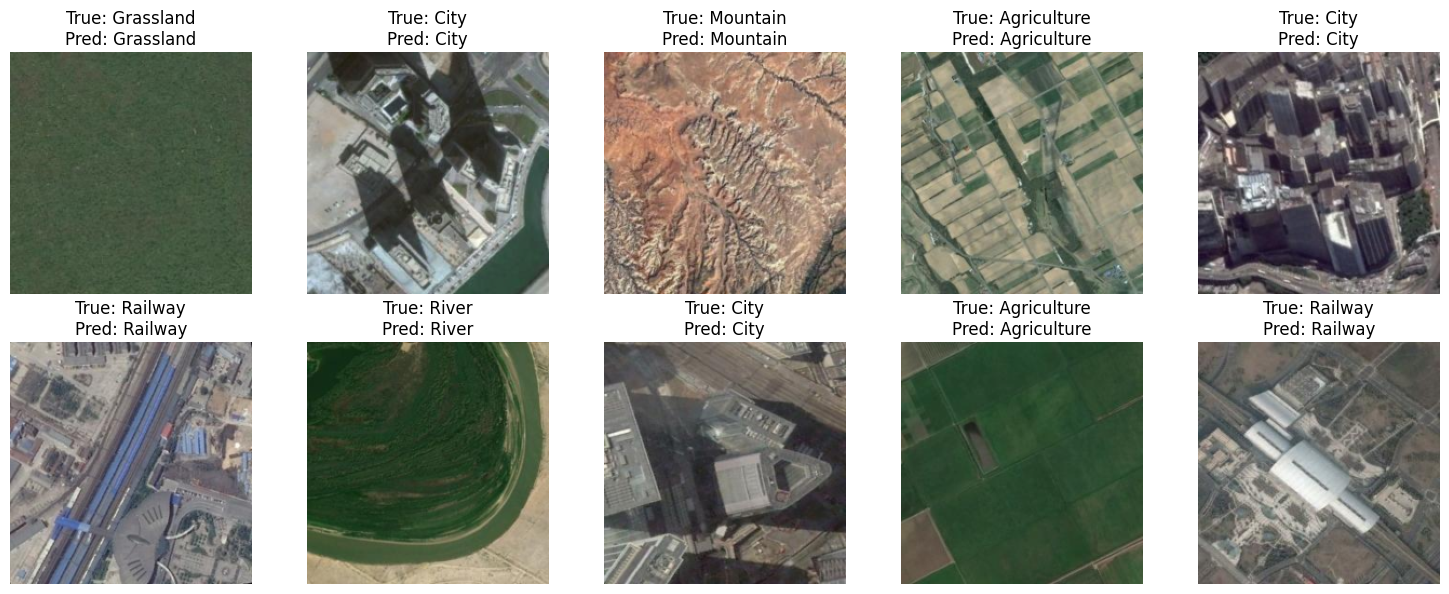

In [34]:
import random
import matplotlib.pyplot as plt

subset = test_loader.dataset
orig_ds = subset.dataset if hasattr(subset, 'dataset') else subset

# random 10 image
indices = random.sample(range(len(subset)), 10)

model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, idx in zip(axes.flatten(), indices):
    img, true_label = subset[idx]
    with torch.no_grad():
        pred_label = model(img.unsqueeze(0).to(device)).argmax(dim=1).item()
    img_disp = img * 0.5 + 0.5
    np_img = img_disp.cpu().permute(1, 2, 0).numpy()
    ax.imshow(np_img)
    ax.axis('off')
    ax.set_title(f"True: {orig_ds.classes[true_label]}\nPred: {orig_ds.classes[pred_label]}")

plt.tight_layout()
plt.show()


# MachineLearning_SVM

## Data processing

In [ ]:
import os
import cv2

def process_image(img, size=(224, 224)):
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2. Resize the image
    resized = cv2.resize(gray, size)
    return resized

def process_all_images(root_dir, save_dir):
    """
    Traverse all subfolders under root_dir, process each image,
    and save them to save_dir preserving the same folder structure.
    """
    # Create the target save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Iterate over each category folder (e.g., Agriculture, Airport, Beach, etc.)
    for category in os.listdir(root_dir):
        category_path = os.path.join(root_dir, category)
        if not os.path.isdir(category_path):
            continue
        
        # Create the corresponding category folder in the save directory
        save_category_path = os.path.join(save_dir, category)
        os.makedirs(save_category_path, exist_ok=True)

        # Iterate over all image files in the category folder
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if not os.path.isfile(img_path):
                continue

            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image file {img_path}")
                continue

            # Process the image
            processed_img = process_image(img, size=(224, 224))

            # Save the processed image to the target folder
            save_img_path = os.path.join(save_category_path, img_name)
            cv2.imwrite(save_img_path, processed_img)


# Execute the script
if __name__ == "__main__":
    root_dir = r"D:\9517project\Aerial_Landscapes"
    save_dir = r"D:\9517project\processed_data"

    process_all_images(root_dir, save_dir)
    print("Image processing completed!")


## Feautures Extraction with Resnet

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np

def main():
    data_dir = r"D:\9517project\Aerial_Landscapes"
    batch_size = 32
    num_workers = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data save paths
    train_feature_save_path = r"D:\9517project\train_data\deep_features.npy"
    train_labels_save_path  = r"D:\9517project\train_data\deep_labels.npy"
    test_feature_save_path  = r"D:\9517project\test_data\deep_features.npy"
    test_labels_save_path   = r"D:\9517project\test_data\deep_labels.npy"

    # Image preprocessing, matching the pretrained network
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Load dataset
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_total = len(dataset)
    num_train = int(num_total * 0.8)
    num_test  = num_total - num_train

    # Randomly split into training and test sets
    train_dataset, test_dataset = random_split(dataset, [num_train, num_test],
                                               generator=torch.Generator().manual_seed(42))
    print(f"Total samples: {num_total}, Training: {num_train}, Testing: {num_test}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Load pretrained ResNet-18 and switch to feature extraction mode
    resnet = models.resnet18(pretrained=True)
    resnet.eval()
    # Replace the fully connected layer with nn.Identity
    resnet.fc = nn.Identity()
    resnet = resnet.to(device)

    def extract_features(data_loader, model, device):
        features_list = []
        labels_list = []
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.to(device)
                feats = model(inputs)  # get [batch_size, 512] feature vectors
                feats = feats.view(feats.size(0), -1)
                features_list.append(feats.cpu().numpy())
                labels_list.append(targets.numpy())
        features_array = np.concatenate(features_list, axis=0)
        labels_array = np.concatenate(labels_list, axis=0)
        return features_array, labels_array

    print("Extracting training set features...")
    X_train, y_train = extract_features(train_loader, resnet, device)
    print("Training features shape:", X_train.shape)

    print("Extracting test set features...")
    X_test, y_test = extract_features(test_loader, resnet, device)
    print("Test features shape:", X_test.shape)

    # Save features and labels
    np.save(train_feature_save_path, X_train)
    np.save(train_labels_save_path, y_train)
    np.save(test_feature_save_path, X_test)
    np.save(test_labels_save_path, y_test)
    print("Deep features saved.")

if __name__ == '__main__':
    main()


## Training

In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load the deep feature training data
train_features_path = r"D:\9517project\train_data\deep_features.npy"
train_labels_path   = r"D:\9517project\train_data\deep_labels.npy"
X_train = np.load(train_features_path)
y_train = np.load(train_labels_path)

print("Training feature shape:", X_train.shape)
print("Training label count:", y_train.shape)

# Define the parameter grid (to strengthen regularization)
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2']
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Build a LinearSVC model and perform hyperparameter search with GridSearchCV
svm = LinearSVC(dual=False, random_state=42, max_iter=10000)
grid_search = GridSearchCV(svm, param_grid, cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Save the best model
model_save_path = r"D:\9517project\svm_model.joblib"
joblib.dump(best_model, model_save_path)
print("Best model saved to:", model_save_path)

Training feature shape: (9600, 512)
Training label count: (9600,)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation accuracy: 0.9309375000000001
Best model saved to: D:\9517project\svm_deep_model_regularized.joblib


## Test

Model loaded: D:\9517project\svm_model.joblib
Test data shape: (2400, 512)
Test label count: (2400,)
Test set accuracy: 0.9370833333333334
Test set classification report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       159
           1       0.87      0.92      0.90       149
           2       0.97      0.96      0.96       178
           3       0.92      0.92      0.92       163
           4       0.98      0.97      0.98       160
           5       0.94      0.95      0.95       142
           6       0.96      0.97      0.96       173
           7       0.94      0.94      0.94       156
           8       0.87      0.92      0.90       172
           9       0.94      0.97      0.96       179
          10       0.97      0.98      0.97       145
          11       0.98      0.96      0.97       165
          12       0.85      0.83      0.84       141
          13       0.96      0.96      0.96       148
          14      

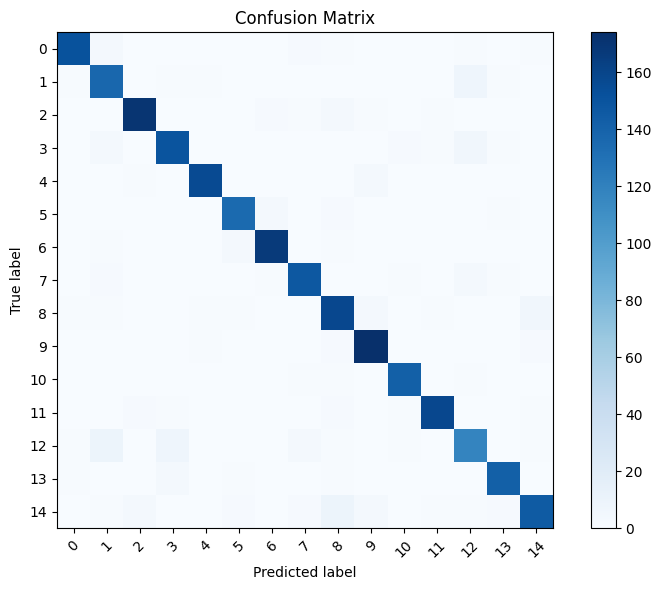

In [38]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

# 1. Load the model
model_path = r"D:\9517project\svm_model.joblib"
svm_model = joblib.load(model_path)
print(f"Model loaded: {model_path}")

# 2. Load test data
X_test = np.load(r"D:\9517project\test_data\deep_features.npy")
y_test = np.load(r"D:\9517project\test_data\deep_labels.npy")
print("Test data shape:", X_test.shape)
print("Test label count:", y_test.shape)

# 3. Predict
y_pred = svm_model.predict(X_test)

# 4. Calculate and print accuracy and classification report
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy:", acc)
print("Test set classification report:")
print(classification_report(y_test, y_pred))

# 5. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 6. Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = np.unique(y_test)
tick = np.arange(len(classes))
plt.xticks(tick, classes, rotation=45)
plt.yticks(tick, classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()
